# Coarse Grid Search with Statistical Validation

This notebook implements a two-stage approach:
1. **Coarse Grid**: Generate 25 configurations (5 servers × 5 cooks), run pilot study (n=20)
2. **Ranking & Validation**: Rank by mean performance, validate sample size, select top 5
3. **Refined Comparison**: Run pairwise tests on top 5 configurations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from parameters import SingleDishParameters
from statistical_validation import (
    generate_coarse_grid,
    run_pilot_study,
    estimate_sample_size_for_ci,
    validate_sample_size,
    rank_configs_by_metric,
    run_crn_paired,
    sequential_sample
)

# Set up plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
np.set_printoptions(precision=3, suppress=True)


## 1. Coarse Grid Generation

Generate all combinations of servers × cooks with fixed tables (20).


In [2]:
# Define grid parameters
table_count = 20  # Fixed
server_range = [3, 4, 5, 6, 7]  # 5 levels
cook_range = [3, 4, 5, 6, 7]    # 5 levels

# Generate base parameters
base_params = SingleDishParameters()

# Generate coarse grid
coarse_grid = generate_coarse_grid(
    table_count=table_count,
    server_range=server_range,
    cook_range=cook_range,
    base_params=base_params
)

print(f"Generated {len(coarse_grid)} configurations:")
print(f"  Servers: {server_range} ({len(server_range)} levels)")
print(f"  Cooks: {cook_range} ({len(cook_range)} levels)")
print(f"  Tables: {table_count} (fixed)")
print(f"  Total: {len(server_range)} × {len(cook_range)} = {len(coarse_grid)} configs")


Generated 25 configurations:
  Servers: [3, 4, 5, 6, 7] (5 levels)
  Cooks: [3, 4, 5, 6, 7] (5 levels)
  Tables: 20 (fixed)
  Total: 5 × 5 = 25 configs


## 2. Two-Stage Pilot Study

**Stage 1**: Run small initial pilot (n=10) to estimate variance and determine required sample size.
**Stage 2**: Run full pilot with adequate n based on validation.


In [3]:
# Stage 1: Initial small pilot to estimate variance
n_initial = 10  # Small initial sample
base_seed_pilot = 1000

print("=" * 70)
print("STAGE 1: Initial Pilot Study (n=10 per configuration)")
print("=" * 70)

initial_pilot_results = run_pilot_study(
    configs=coarse_grid,
    n_rep=n_initial,
    base_seed=base_seed_pilot
)

print(f"\nInitial pilot complete: {len(initial_pilot_results)} configurations × {n_initial} replications")


STAGE 1: Initial Pilot Study (n=10 per configuration)
Running pilot study: 25 configs × 10 replications
Config 1/25: 3 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 2/25: 3 servers, 4 cooks ... ✓ (avg runtime: 0.01s)
Config 3/25: 3 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 4/25: 3 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 5/25: 3 servers, 7 cooks ... ✓ (avg runtime: 0.02s)
Config 6/25: 4 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 7/25: 4 servers, 4 cooks ... ✓ (avg runtime: 0.01s)
Config 8/25: 4 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 9/25: 4 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 10/25: 4 servers, 7 cooks ... ✓ (avg runtime: 0.02s)
Config 11/25: 5 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 12/25: 5 servers, 4 cooks ... ✓ (avg runtime: 0.01s)
Config 13/25: 5 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 14/25: 5 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 15/25: 5 servers, 7 cooks ... ✓ (avg runtime: 0.02s)
Confi

## 3. Sample Size Validation and Determination

Validate initial pilot results and determine required n for full pilot.


In [4]:
# Validate sample size from initial pilot
target_half_width_rel = 0.05  # 5% relative half-width
validation_results = validate_sample_size(
    pilot_results=initial_pilot_results,
    target_half_width_rel=target_half_width_rel,
    metric='net_revpash'
)

# Display validation summary
print("\n" + "=" * 70)
print("SAMPLE SIZE VALIDATION (Target: 5% relative CI half-width)")
print("=" * 70)

# Find max required n across all configs
max_required_n = max(v['required_n'] for v in validation_results.values())
min_required_n = min(v['required_n'] for v in validation_results.values())

# Determine final pilot n
n_min = 20  # Minimum n for pilot study
n_final_pilot = max(max_required_n, n_min)

print(f"\nRequired n per configuration (from initial pilot):")
print(f"  Minimum required: {min_required_n}")
print(f"  Maximum required: {max_required_n}")
print(f"\n📊 Final pilot n: {n_final_pilot} (max(required_n, {n_min}))")

# Show configs that need more than initial n
configs_needing_more = [(k, v['required_n']) for k, v in validation_results.items() 
                        if v['required_n'] > n_initial]
if configs_needing_more:
    print(f"\n⚠️  {len(configs_needing_more)} configurations need more than initial n={n_initial}:")
    for config_key, n_req in sorted(configs_needing_more, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {config_key}: n_required = {n_req}")
    if len(configs_needing_more) > 5:
        print(f"  ... ({len(configs_needing_more) - 5} more)")

# Display CV statistics
cvs = [v['cv'] for v in validation_results.values()]
print(f"\nCoefficient of Variation (CV) statistics from initial pilot:")
print(f"  Mean CV: {np.mean(cvs):.4f}")
print(f"  Std CV: {np.std(cvs):.4f}")
print(f"  Min CV: {np.min(cvs):.4f}")
print(f"  Max CV: {np.max(cvs):.4f}")



SAMPLE SIZE VALIDATION (Target: 5% relative CI half-width)

Required n per configuration (from initial pilot):
  Minimum required: 9
  Maximum required: 37

📊 Final pilot n: 37 (max(required_n, 20))

⚠️  22 configurations need more than initial n=10:
  config_14_5s_7c: n_required = 37
  config_13_5s_6c: n_required = 23
  config_10_5s_3c: n_required = 22
  config_18_6s_6c: n_required = 22
  config_23_7s_6c: n_required = 22
  ... (17 more)

Coefficient of Variation (CV) statistics from initial pilot:
  Mean CV: 0.0943
  Std CV: 0.0192
  Min CV: 0.0617
  Max CV: 0.1485


In [5]:
# Stage 2: Full pilot study with adequate n
print("\n" + "=" * 70)
print(f"STAGE 2: Full Pilot Study (n={n_final_pilot} per configuration)")
print("=" * 70)

# Calculate how many additional replications needed per config
additional_reps = n_final_pilot - n_initial

if additional_reps > 0:
    print(f"\nRunning additional {additional_reps} replications per configuration...")
    
    # Run additional replications
    additional_pilot_results = run_pilot_study(
        configs=coarse_grid,
        n_rep=additional_reps,
        base_seed=base_seed_pilot + n_initial  # Continue from where we left off
    )
    
    # Combine initial and additional results
    pilot_results = {}
    for config_key in initial_pilot_results.keys():
        pilot_results[config_key] = {}
        for metric_key in initial_pilot_results[config_key].keys():
            initial_data = initial_pilot_results[config_key][metric_key]
            additional_data = additional_pilot_results[config_key][metric_key]
            pilot_results[config_key][metric_key] = np.concatenate([initial_data, additional_data])
    
    print(f"\nFull pilot complete: {len(pilot_results)} configurations × {n_final_pilot} replications")
else:
    # n_initial was already sufficient
    pilot_results = initial_pilot_results
    print(f"\nInitial pilot n={n_initial} was already sufficient. Using initial results.")



STAGE 2: Full Pilot Study (n=37 per configuration)

Running additional 27 replications per configuration...
Running pilot study: 25 configs × 27 replications
Config 1/25: 3 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 2/25: 3 servers, 4 cooks ... ✓ (avg runtime: 0.02s)
Config 3/25: 3 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 4/25: 3 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 5/25: 3 servers, 7 cooks ... ✓ (avg runtime: 0.02s)
Config 6/25: 4 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 7/25: 4 servers, 4 cooks ... ✓ (avg runtime: 0.01s)
Config 8/25: 4 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 9/25: 4 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 10/25: 4 servers, 7 cooks ... ✓ (avg runtime: 0.02s)
Config 11/25: 5 servers, 3 cooks ... ✓ (avg runtime: 0.01s)
Config 12/25: 5 servers, 4 cooks ... ✓ (avg runtime: 0.01s)
Config 13/25: 5 servers, 5 cooks ... ✓ (avg runtime: 0.02s)
Config 14/25: 5 servers, 6 cooks ... ✓ (avg runtime: 0.02s)
Config 15/

## 5. Ranking Configurations

Rank all configurations by mean Net RevPASH and display top 10.


In [7]:
# Rank configurations by Net RevPASH
rankings = rank_configs_by_metric(pilot_results, metric='net_revpash')

print("\n" + "=" * 70)
print("CONFIGURATION RANKINGS (by Net RevPASH mean)")
print("=" * 70)
print(f"\n{'Rank':<6} {'Config':<25} {'Mean':<12} {'Std':<12} {'CV':<10}")
print("-" * 70)

# Display top 10
top_n_display = 10
for rank, (config_key, mean, std, n) in enumerate(rankings[:top_n_display], 1):
    cv = std / mean if mean != 0 else 0.0
    print(f"{rank:<6} {config_key:<25} {mean:<12.2f} {std:<12.2f} {cv:<10.4f}")

print(f"\n... ({len(rankings) - top_n_display} more configurations)")



CONFIGURATION RANKINGS (by Net RevPASH mean)

Rank   Config                    Mean         Std          CV        
----------------------------------------------------------------------
1      config_9_4s_7c            15.71        1.35         0.0862    
2      config_14_5s_7c           15.62        1.72         0.1102    
3      config_8_4s_6c            15.39        1.50         0.0976    
4      config_19_6s_7c           15.29        1.74         0.1138    
5      config_13_5s_6c           15.24        1.67         0.1099    
6      config_18_6s_6c           14.75        1.36         0.0925    
7      config_24_7s_7c           14.63        1.67         0.1140    
8      config_23_7s_6c           14.48        1.32         0.0911    
9      config_3_3s_6c            14.46        1.17         0.0806    
10     config_4_3s_7c            13.99        1.18         0.0841    

... (15 more configurations)


## 6. Top 5 Selection and Pairwise Comparisons

Select top 5 configurations and run pairwise CRN tests.


In [8]:
# Select top 5 configurations
top_5_count = 5
top_5_rankings = rankings[:top_5_count]

print("\n" + "=" * 70)
print(f"TOP {top_5_count} CONFIGURATIONS SELECTED")
print("=" * 70)
print(f"\n{'Rank':<6} {'Config':<25} {'Mean Net RevPASH':<18} {'Table Turnover':<16}")
print("-" * 86)

top_5_configs = []
for rank, (config_key, mean, std, n) in enumerate(top_5_rankings, 1):
    # Get table turnover data for configuration
    if config_key in pilot_results and 'table_turnover' in pilot_results[config_key]:
        table_turn_vals = pilot_results[config_key]['table_turnover']
        table_turn_mean = np.mean(table_turn_vals)
    else:
        table_turn_mean = float('nan')
    print(f"{rank:<6} {config_key:<25} {mean:<18.2f} {table_turn_mean:<16.2f}")
    
    # Find corresponding config from coarse_grid
    # Extract server and cook numbers from config_key
    # Format: "config_X_Ys_Zc" where X is index, Y is servers, Z is cooks
    parts = config_key.split('_')
    server_idx = int(parts[1])  # Index in coarse_grid
    top_5_configs.append(coarse_grid[server_idx])

print(f"\nSelected {len(top_5_configs)} configurations for pairwise comparison")



TOP 5 CONFIGURATIONS SELECTED

Rank   Config                    Mean Net RevPASH   Table Turnover  
--------------------------------------------------------------------------------------
1      config_9_4s_7c            15.71              0.70            
2      config_14_5s_7c           15.62              0.70            
3      config_8_4s_6c            15.39              0.67            
4      config_19_6s_7c           15.29              0.71            
5      config_13_5s_6c           15.24              0.67            

Selected 5 configurations for pairwise comparison


In [9]:
# Run pairwise CRN tests on top 5 configurations and summarize "important" differences; identify the overall best config

print("\n" + "=" * 70)
print("PAIRWISE CRN TESTS (Top 5 Configurations)")
print("=" * 70)

n_pairwise = 50  # More replications for refined comparison
base_seed_pairwise = 2000

pairwise_results = {}
win_counts = {i: 0 for i in range(len(top_5_configs))}
significance_matrix = np.zeros((len(top_5_configs), len(top_5_configs)), dtype=int)

# Helper for config display
def config_label(config):
    return f"{config.num_servers}s_{config.num_cooks}c"

# Run all pairwise comparisons with improved results summary
comparison_table = []
for i, config_A in enumerate(top_5_configs):
    for j, config_B in enumerate(top_5_configs):
        if i >= j:
            continue  # Only compare each pair once, skip diagonal and repeats
        
        config_key_A = config_label(config_A)
        config_key_B = config_label(config_B)
        pair_key = f"{config_key_A} vs {config_key_B}"

        result = run_crn_paired(
            config_pair=(config_A, config_B),
            n_rep=n_pairwise,
            base_seed=base_seed_pairwise
        )
        pairwise_results[pair_key] = result

        mean_diff = result['mean_diff']
        ci_lower = result['ci_lower']
        ci_upper = result['ci_upper']
        p_value = result['p_value']

        # Build comparison row for later summary
        comparison_table.append({
            'A': config_key_A,
            'B': config_key_B,
            'mean_diff': mean_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'p_value': p_value,
        })

        # Output each paired comparison in a clear format
        print(f"\n[{config_key_A} vs {config_key_B}]")
        print(f"  Mean difference (A - B): {mean_diff:.2f}")
        print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
        print(f"  p-value: {p_value:.4f}")

        if p_value < 0.05:
            if mean_diff > 0:
                print(f"  ✓ Significant: {config_key_A} > {config_key_B} (p < 0.05)")
                win_counts[i] += 1
                # Mark significance for later
                significance_matrix[i, j] = 1
            else:
                print(f"  ✓ Significant: {config_key_B} > {config_key_A} (p < 0.05)")
                win_counts[j] += 1
                significance_matrix[j, i] = 1
        else:
            print(f"  ✗ Not significant: No difference detected (p ≥ 0.05)")

print("\n" + "=" * 70)
print("PAIRWISE COMPARISONS SUMMARY")
print("=" * 70)

# Tabular summary of all pairwise, marking important (statistically significant) differences
summary_rows = []
for row in comparison_table:
    winner = None
    if row['p_value'] < 0.05:
        if row['mean_diff'] > 0:
            winner = row['A']
        else:
            winner = row['B']
    summary_rows.append({
        'A': row['A'],
        'B': row['B'],
        'mean_diff': f"{row['mean_diff']:.2f}",
        'ci': f"[{row['ci_lower']:.2f}, {row['ci_upper']:.2f}]",
        'p_value': f"{row['p_value']:.4f}",
        'winner': winner if winner else "No significant diff"
    })

# Print formatted table without tabulate
headers = ["Config A", "Config B", "Mean Diff", "95% CI", "p-value", "Winner (p<0.05)"]
col_widths = [15, 15, 12, 20, 10, 20]

# Print header
header_line = " | ".join(h.ljust(w) for h, w in zip(headers, col_widths))
print(header_line)
print("-" * len(header_line))

# Print rows
for row in summary_rows:
    row_line = " | ".join([
        row['A'].ljust(col_widths[0]),
        row['B'].ljust(col_widths[1]),
        row['mean_diff'].ljust(col_widths[2]),
        row['ci'].ljust(col_widths[3]),
        row['p_value'].ljust(col_widths[4]),
        row['winner'].ljust(col_widths[5])
    ])
    print(row_line)

print("\n" + "=" * 70)

# Now recommend the "best" configuration, with justification
# Approach: pick the config that has the most statistically significant wins in the head-to-head, or break ties by highest mean

most_wins = max(win_counts.values())
candidates = [i for i, wins in win_counts.items() if wins == most_wins]

if len(candidates) == 1:
    best_idx = candidates[0]
    best_config = top_5_configs[best_idx]
    print(f"\nOVERALL BEST CONFIGURATION (statistically significant wins): {config_label(best_config)}")
elif len(candidates) > 1:
    # tie: select by highest mean Net RevPASH among tied configs
    best_idx = candidates[0]
    best_config = top_5_configs[best_idx]
    print(f"\nTIE between configurations: {[config_label(top_5_configs[i]) for i in candidates]}")
    # Greedy tie-break by mean Net RevPASH (calculated previously)
    best_mean = -np.inf
    for i in candidates:
        cfg_key = [k for k in pilot_results.keys() if config_label(top_5_configs[i]) in k][0]
        mean_val = np.mean(pilot_results[cfg_key]['net_revpash'])
        if mean_val > best_mean:
            best_mean = mean_val
            best_idx = i
    best_config = top_5_configs[best_idx]
    print(f"✓ Highest mean Net RevPASH breaks tie: {config_label(best_config)} (mean={best_mean:.2f})")
else:
    print("\nNo clear winner found; all pairwise differences are not statistically significant.")

print(f"\nRecommended Configuration: {config_label(best_config)}")
print("=" * 70)



PAIRWISE CRN TESTS (Top 5 Configurations)
Running CRN paired comparison: 50 replications
  Config A: 4 servers, 7 cooks
  Config B: 5 servers, 7 cooks
  Progress: 50/50 replications ✓

[4s_7c vs 5s_7c]
  Mean difference (A - B): -0.39
  95% CI: [-0.74, -0.05]
  p-value: 0.0273
  ✓ Significant: 5s_7c > 4s_7c (p < 0.05)
Running CRN paired comparison: 50 replications
  Config A: 4 servers, 7 cooks
  Config B: 4 servers, 6 cooks
  Progress: 50/50 replications ✓

[4s_7c vs 4s_6c]
  Mean difference (A - B): 0.40
  95% CI: [0.01, 0.80]
  p-value: 0.0452
  ✓ Significant: 4s_7c > 4s_6c (p < 0.05)
Running CRN paired comparison: 50 replications
  Config A: 4 servers, 7 cooks
  Config B: 6 servers, 7 cooks
  Progress: 50/50 replications ✓

[4s_7c vs 6s_7c]
  Mean difference (A - B): 0.31
  95% CI: [-0.10, 0.72]
  p-value: 0.1390
  ✗ Not significant: No difference detected (p ≥ 0.05)
Running CRN paired comparison: 50 replications
  Config A: 4 servers, 7 cooks
  Config B: 5 servers, 6 cooks
  Prog

In [10]:
# Calculate mean runtime per replication
mean_runtime = np.mean([np.mean(r['runtime']) for r in pilot_results.values()])

print("=" * 70)
print("RECOMMENDED REPLICATION COUNTS AND RUNTIME ESTIMATES")
print("=" * 70)
print(f"\nMean runtime per replication: {mean_runtime:.2f} seconds")
print(f"\nTwo-stage pilot approach:")
print(f"  Stage 1 (initial pilot): n = {n_initial} per configuration")
print(f"    Total: {len(coarse_grid) * n_initial * mean_runtime:.1f} seconds")
print(f"  Stage 2 (additional reps): n = {additional_reps} per configuration")
print(f"    Total: {len(coarse_grid) * additional_reps * mean_runtime:.1f} seconds")
print(f"  Full pilot total: n = {n_final_pilot} per configuration")
print(f"    Total: {len(coarse_grid) * n_final_pilot * mean_runtime:.1f} seconds")
print(f"    ({len(coarse_grid) * n_final_pilot * mean_runtime/60:.1f} minutes)")

print(f"\nRefined pairwise comparison:")
print(f"  n = {n_pairwise} per pair")
num_pairs = top_5_count * (top_5_count - 1) // 2  # 10 pairs
print(f"  Total: {num_pairs} pairs × {n_pairwise} reps = {num_pairs * n_pairwise * 2 * mean_runtime:.1f} seconds")
print(f"    ({num_pairs * n_pairwise * 2 * mean_runtime/60:.1f} minutes)")

print(f"\nFull experimental workflow estimates:")
total_runtime = (len(coarse_grid) * n_final_pilot + num_pairs * n_pairwise * 2) * mean_runtime
print(f"  Total expected runtime: {total_runtime:.1f} seconds ({total_runtime/60:.1f} minutes)")

print(f"\n✓ Sample size validation ensured n={n_final_pilot} is sufficient for all configurations")
print(f"  (Required n ranged from {min_required_n} to {max_required_n})")
print("\n" + "=" * 70)


RECOMMENDED REPLICATION COUNTS AND RUNTIME ESTIMATES

Mean runtime per replication: 0.02 seconds

Two-stage pilot approach:
  Stage 1 (initial pilot): n = 10 per configuration
    Total: 4.1 seconds
  Stage 2 (additional reps): n = 27 per configuration
    Total: 11.0 seconds
  Full pilot total: n = 37 per configuration
    Total: 15.1 seconds
    (0.3 minutes)

Refined pairwise comparison:
  n = 50 per pair
  Total: 10 pairs × 50 reps = 16.3 seconds
    (0.3 minutes)

Full experimental workflow estimates:
  Total expected runtime: 31.4 seconds (0.5 minutes)

✓ Sample size validation ensured n=37 is sufficient for all configurations
  (Required n ranged from 9 to 37)



## 7. Visualization: Heatmaps and Performance Analysis

Generate comprehensive visualizations to analyze performance across all configurations.


In [11]:
# Prepare data for visualization
import pandas as pd
import seaborn as sns

# Extract configuration data from pilot_results
config_data = []
for config_key, config_results in pilot_results.items():
    # Parse config_key: "config_X_Ys_Zc" where X is index, Y is servers, Z is cooks
    parts = config_key.split('_')
    config_idx = int(parts[1])
    num_servers = coarse_grid[config_idx].num_servers
    num_cooks = coarse_grid[config_idx].num_cooks
    
    config_data.append({
        'config_key': config_key,
        'num_servers': num_servers,
        'num_cooks': num_cooks,
        'net_revpash_mean': np.mean(config_results['net_revpash']),
        'net_revpash_std': np.std(config_results['net_revpash'], ddof=1),
        'revpash_mean': np.mean(config_results['revpash']),
        'revpash_std': np.std(config_results['revpash'], ddof=1),
        'table_turnover_mean': np.mean(config_results['table_turnover']),
        'parties_served_mean': np.mean(config_results['parties_served']),
        'total_revenue_mean': np.mean(config_results['total_revenue']),
        'server_utilization_mean': np.mean(config_results['server_utilization']),
        'cook_utilization_mean': np.mean(config_results['avg_cook_utilization']),
        'avg_wait_table_mean': np.mean(config_results['avg_wait_table']),
        'avg_kitchen_time_mean': np.mean(config_results['avg_kitchen_time']),
    })

# Create DataFrame
viz_df = pd.DataFrame(config_data)

print("Data prepared for visualization:")
print(f"  {len(viz_df)} configurations")
print(f"  Server range: {viz_df['num_servers'].min()} - {viz_df['num_servers'].max()}")
print(f"  Cook range: {viz_df['num_cooks'].min()} - {viz_df['num_cooks'].max()}")
print(f"\nTop 5 configurations by Net RevPASH:")
print(viz_df.nlargest(5, 'net_revpash_mean')[['num_servers', 'num_cooks', 'net_revpash_mean', 'server_utilization_mean', 'cook_utilization_mean']])


Data prepared for visualization:
  25 configurations
  Server range: 3 - 7
  Cook range: 3 - 7

Top 5 configurations by Net RevPASH:
    num_servers  num_cooks  net_revpash_mean  server_utilization_mean  \
9             4          7         15.714381                 0.668203   
14            5          7         15.616813                 0.539950   
8             4          6         15.385293                 0.641183   
19            6          7         15.288468                 0.452967   
13            5          6         15.239291                 0.521036   

    cook_utilization_mean  
9                0.799423  
14               0.806083  
8                0.863461  
19               0.804592  
13               0.872092  


### Heatmap Visualizations

Create heatmaps showing performance metrics across different staffing configurations.


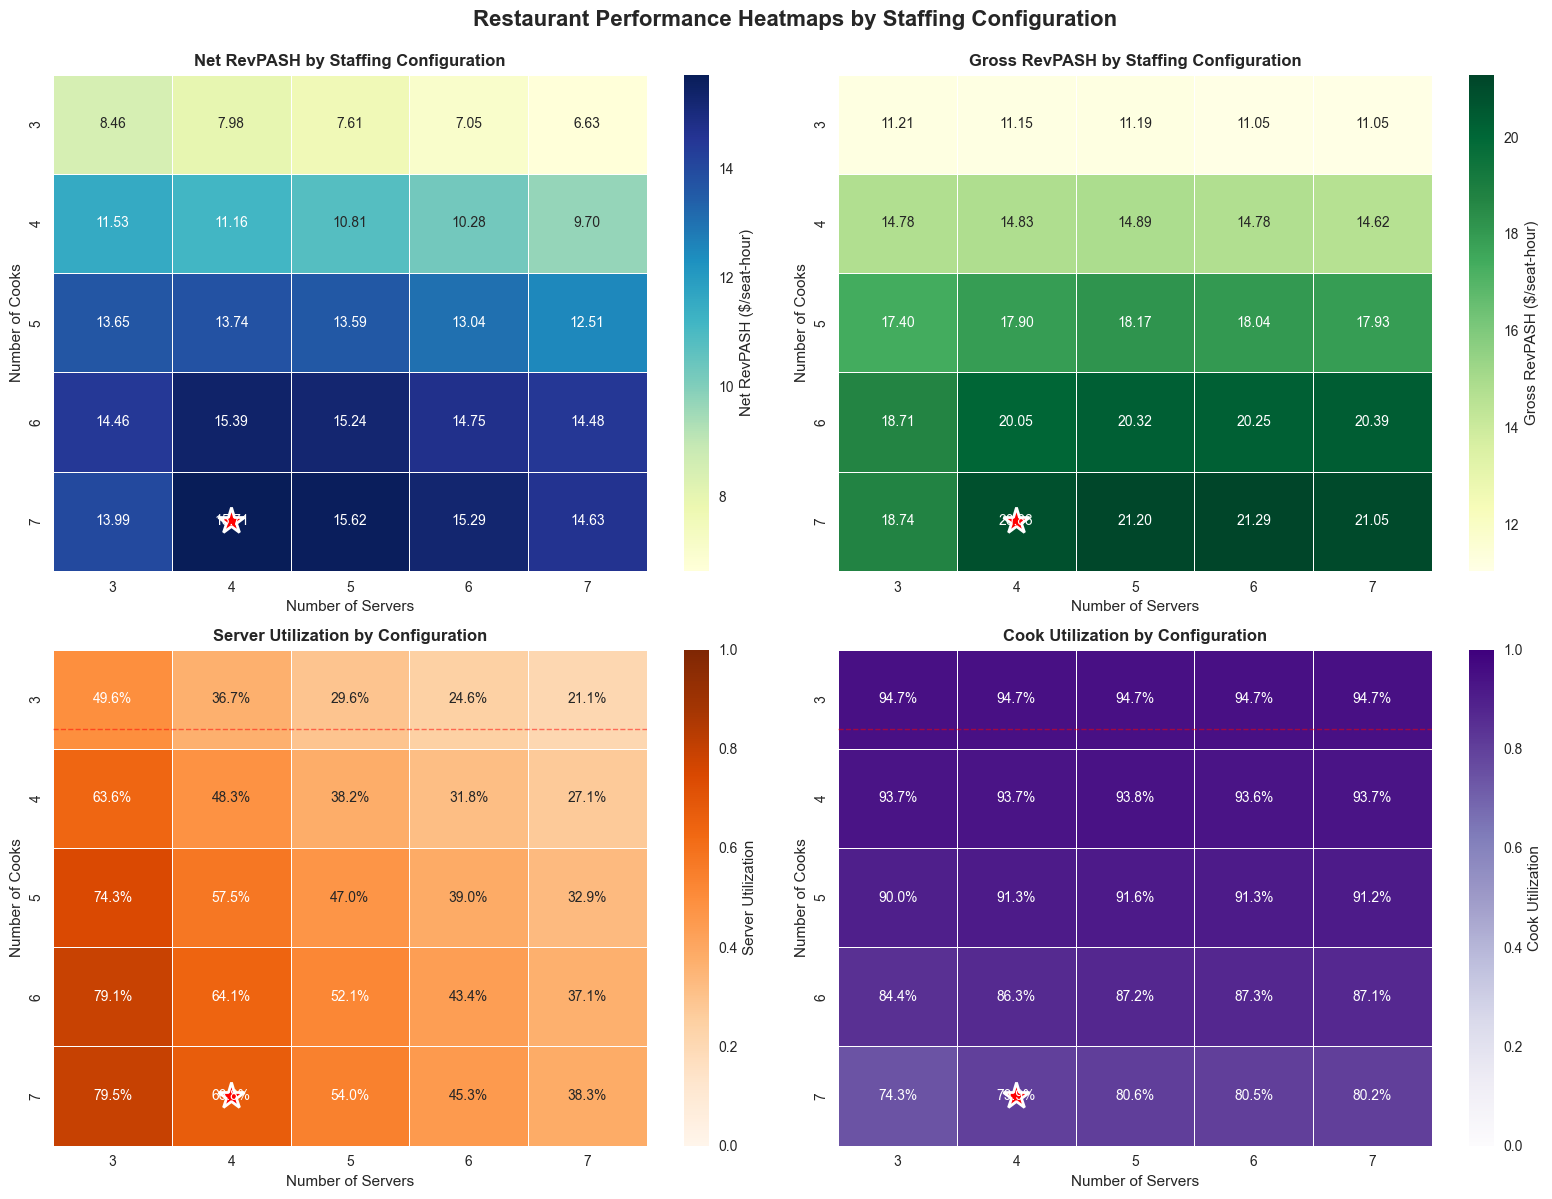


OPTIMAL CONFIGURATION (from heatmaps)
Servers: 4
Cooks: 7
Net RevPASH: $15.71 per seat-hour
Gross RevPASH: $20.88 per seat-hour
Total Revenue: $5011.45
Server Utilization: 66.8%
Cook Utilization: 79.9%


In [12]:
# Create heatmap visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Restaurant Performance Heatmaps by Staffing Configuration', fontsize=16, fontweight='bold', y=0.995)

# 1. Net RevPASH Heatmap
pivot_net_revpash = viz_df.pivot(index='num_cooks', columns='num_servers', values='net_revpash_mean')
sns.heatmap(pivot_net_revpash, annot=True, fmt='.2f', cmap='YlGnBu', 
            cbar_kws={'label': 'Net RevPASH ($/seat-hour)'}, ax=axes[0, 0], linewidths=0.5)
axes[0, 0].set_title('Net RevPASH by Staffing Configuration', fontweight='bold')
axes[0, 0].set_xlabel('Number of Servers')
axes[0, 0].set_ylabel('Number of Cooks')

# Mark optimal configuration
optimal_idx = viz_df['net_revpash_mean'].idxmax()
optimal_config = viz_df.loc[optimal_idx]
optimal_x = optimal_config['num_servers'] - pivot_net_revpash.columns.min() + 0.5
optimal_y = optimal_config['num_cooks'] - pivot_net_revpash.index.min() + 0.5
axes[0, 0].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 2. Gross RevPASH Heatmap
pivot_revpash = viz_df.pivot(index='num_cooks', columns='num_servers', values='revpash_mean')
sns.heatmap(pivot_revpash, annot=True, fmt='.2f', cmap='YlGn', 
            cbar_kws={'label': 'Gross RevPASH ($/seat-hour)'}, ax=axes[0, 1], linewidths=0.5)
axes[0, 1].set_title('Gross RevPASH by Staffing Configuration', fontweight='bold')
axes[0, 1].set_xlabel('Number of Servers')
axes[0, 1].set_ylabel('Number of Cooks')

# Mark optimal
axes[0, 1].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 3. Server Utilization Heatmap
pivot_server_util = viz_df.pivot(index='num_cooks', columns='num_servers', values='server_utilization_mean')
sns.heatmap(pivot_server_util, annot=True, fmt='.1%', cmap='Oranges', vmin=0, vmax=1,
            cbar_kws={'label': 'Server Utilization'}, ax=axes[1, 0], linewidths=0.5)
axes[1, 0].set_title('Server Utilization by Configuration', fontweight='bold')
axes[1, 0].set_xlabel('Number of Servers')
axes[1, 0].set_ylabel('Number of Cooks')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Mark optimal
axes[1, 0].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 4. Cook Utilization Heatmap
pivot_cook_util = viz_df.pivot(index='num_cooks', columns='num_servers', values='cook_utilization_mean')
sns.heatmap(pivot_cook_util, annot=True, fmt='.1%', cmap='Purples', vmin=0, vmax=1,
            cbar_kws={'label': 'Cook Utilization'}, ax=axes[1, 1], linewidths=0.5)
axes[1, 1].set_title('Cook Utilization by Configuration', fontweight='bold')
axes[1, 1].set_xlabel('Number of Servers')
axes[1, 1].set_ylabel('Number of Cooks')
axes[1, 1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Mark optimal
axes[1, 1].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("OPTIMAL CONFIGURATION (from heatmaps)")
print(f"{'='*70}")
print(f"Servers: {optimal_config['num_servers']:.0f}")
print(f"Cooks: {optimal_config['num_cooks']:.0f}")
print(f"Net RevPASH: ${optimal_config['net_revpash_mean']:.2f} per seat-hour")
print(f"Gross RevPASH: ${optimal_config['revpash_mean']:.2f} per seat-hour")
print(f"Total Revenue: ${optimal_config['total_revenue_mean']:.2f}")
print(f"Server Utilization: {optimal_config['server_utilization_mean']:.1%}")
print(f"Cook Utilization: {optimal_config['cook_utilization_mean']:.1%}")
print(f"{'='*70}")


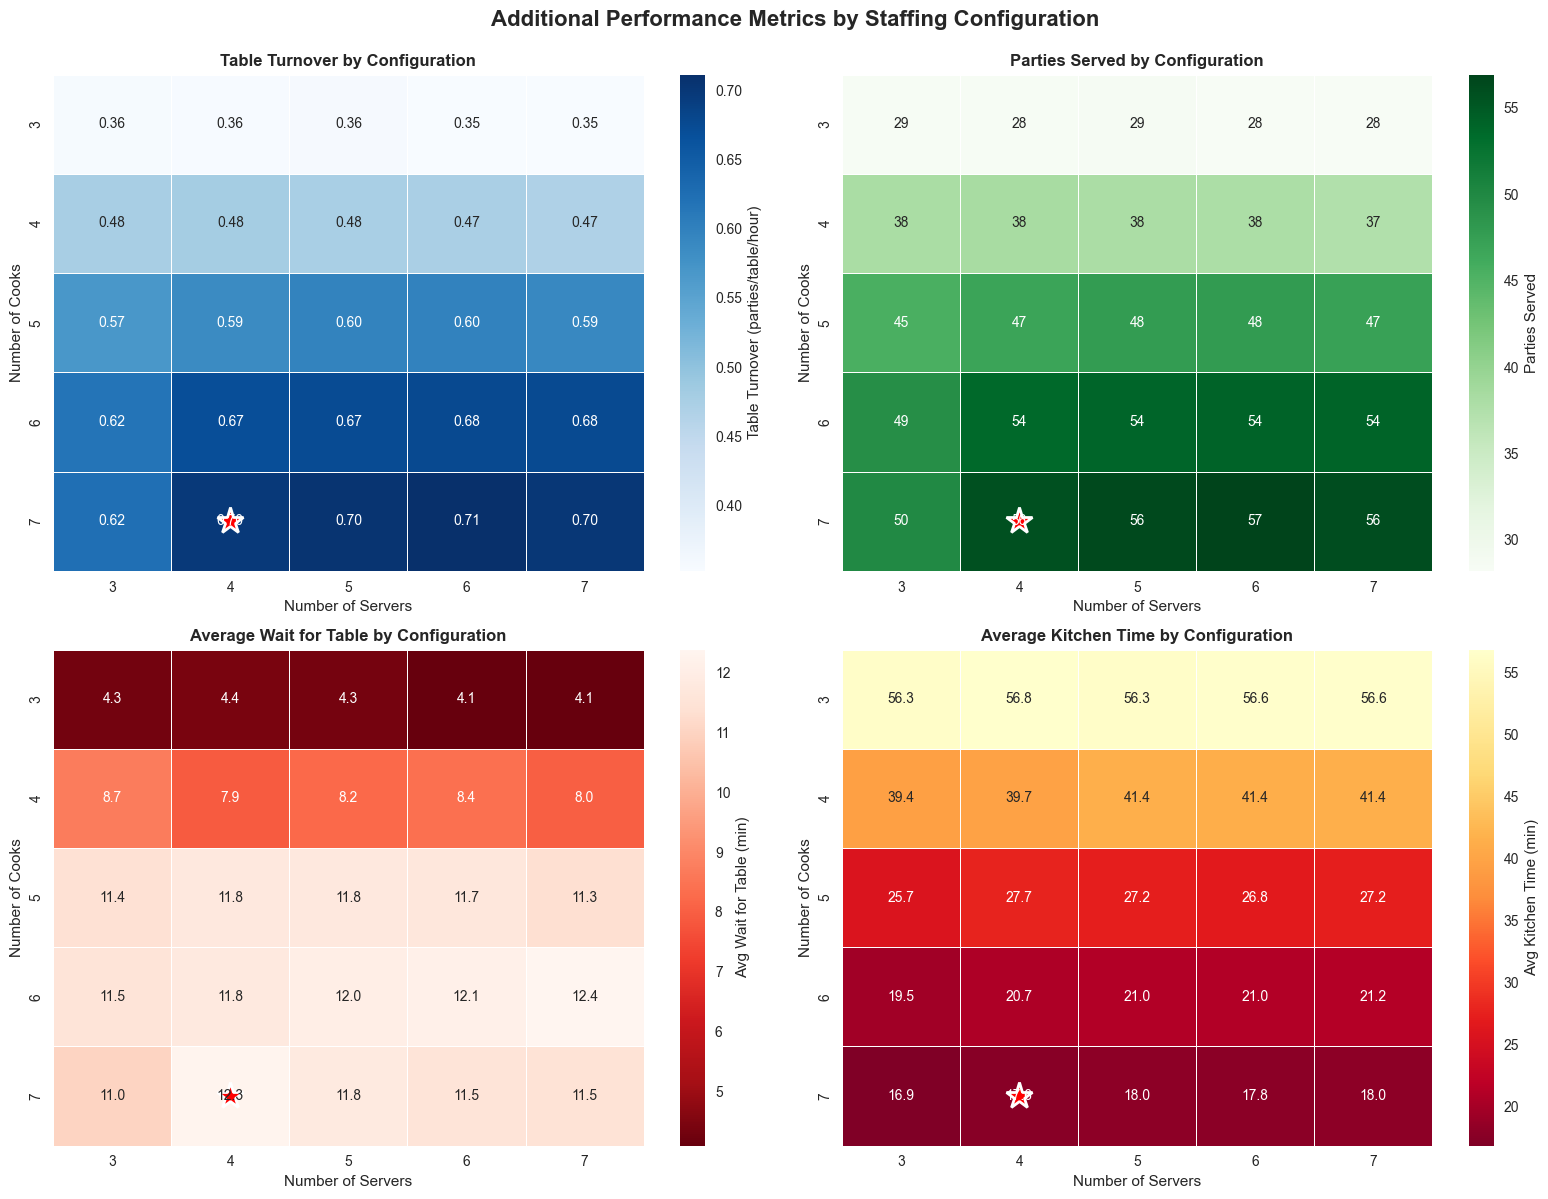

In [13]:
# Additional performance metrics heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Additional Performance Metrics by Staffing Configuration', fontsize=16, fontweight='bold', y=0.995)

# 1. Table Turnover Heatmap
pivot_turnover = viz_df.pivot(index='num_cooks', columns='num_servers', values='table_turnover_mean')
sns.heatmap(pivot_turnover, annot=True, fmt='.2f', cmap='Blues', 
            cbar_kws={'label': 'Table Turnover (parties/table/hour)'}, ax=axes[0, 0], linewidths=0.5)
axes[0, 0].set_title('Table Turnover by Configuration', fontweight='bold')
axes[0, 0].set_xlabel('Number of Servers')
axes[0, 0].set_ylabel('Number of Cooks')
axes[0, 0].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 2. Parties Served Heatmap
pivot_parties = viz_df.pivot(index='num_cooks', columns='num_servers', values='parties_served_mean')
sns.heatmap(pivot_parties, annot=True, fmt='.0f', cmap='Greens', 
            cbar_kws={'label': 'Parties Served'}, ax=axes[0, 1], linewidths=0.5)
axes[0, 1].set_title('Parties Served by Configuration', fontweight='bold')
axes[0, 1].set_xlabel('Number of Servers')
axes[0, 1].set_ylabel('Number of Cooks')
axes[0, 1].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 3. Average Wait for Table Heatmap
pivot_wait_table = viz_df.pivot(index='num_cooks', columns='num_servers', values='avg_wait_table_mean')
sns.heatmap(pivot_wait_table, annot=True, fmt='.1f', cmap='Reds_r', 
            cbar_kws={'label': 'Avg Wait for Table (min)'}, ax=axes[1, 0], linewidths=0.5)
axes[1, 0].set_title('Average Wait for Table by Configuration', fontweight='bold')
axes[1, 0].set_xlabel('Number of Servers')
axes[1, 0].set_ylabel('Number of Cooks')
axes[1, 0].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 4. Average Kitchen Time Heatmap
pivot_kitchen = viz_df.pivot(index='num_cooks', columns='num_servers', values='avg_kitchen_time_mean')
sns.heatmap(pivot_kitchen, annot=True, fmt='.1f', cmap='YlOrRd_r', 
            cbar_kws={'label': 'Avg Kitchen Time (min)'}, ax=axes[1, 1], linewidths=0.5)
axes[1, 1].set_title('Average Kitchen Time by Configuration', fontweight='bold')
axes[1, 1].set_xlabel('Number of Servers')
axes[1, 1].set_ylabel('Number of Cooks')
axes[1, 1].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

plt.tight_layout()
plt.show()


### Performance Trade-offs Analysis

Analyze relationships between different performance metrics.


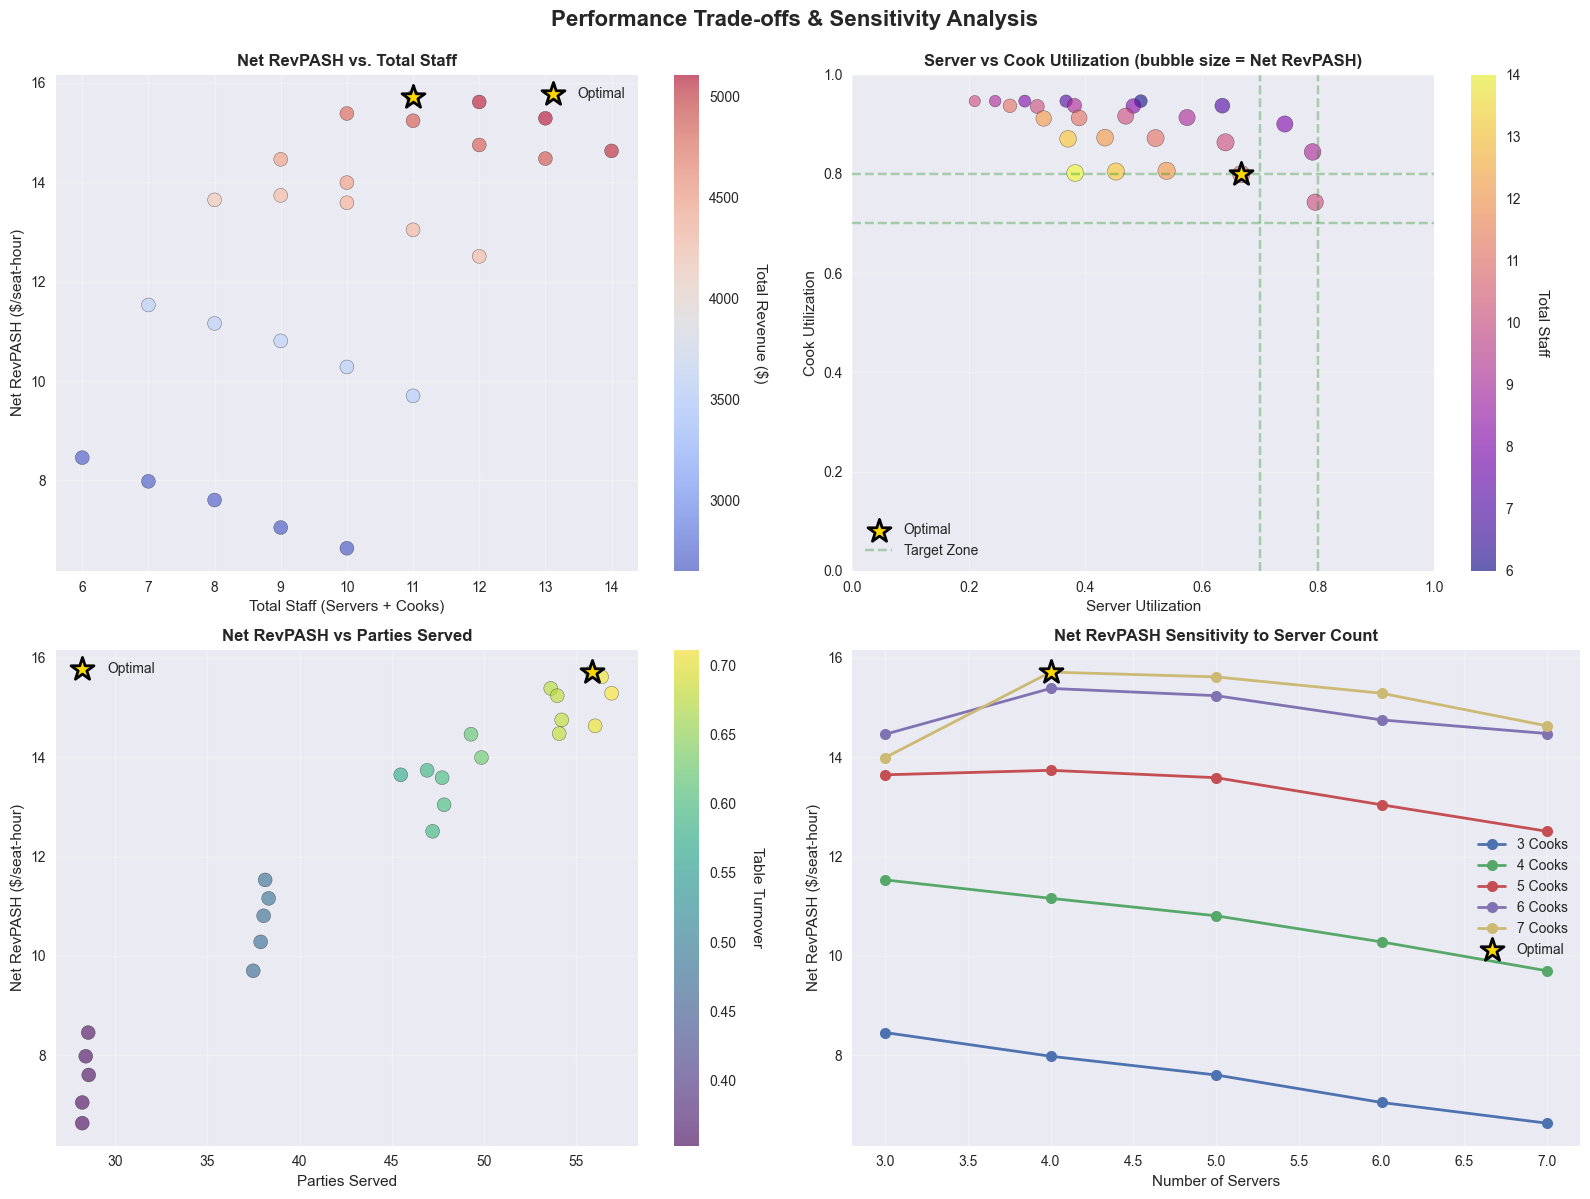


PERFORMANCE SUMMARY

Net RevPASH Statistics:
  Maximum: $15.71
  Minimum: $6.63
  Average: $12.29
  Std Dev: $1.23

Utilization Statistics:
  Server Utilization Range: 21.1% - 79.5%
  Cook Utilization Range: 74.3% - 94.7%

Throughput Statistics:
  Parties Served Range: 28 - 57
  Table Turnover Range: 0.35 - 0.71


In [22]:
# Performance trade-offs analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Trade-offs & Sensitivity Analysis', fontsize=16, fontweight='bold', y=0.995)

# Calculate total staff
viz_df['total_staff'] = viz_df['num_servers'] + viz_df['num_cooks']

# 1. Net RevPASH vs Total Staff
scatter1 = axes[0, 0].scatter(viz_df['total_staff'], 
                             viz_df['net_revpash_mean'],
                             s=100, 
                             alpha=0.6,
                             c=viz_df['total_revenue_mean'],
                             cmap='coolwarm',
                             edgecolors='black')
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Total Revenue ($)', rotation=270, labelpad=20)

# Mark optimal
optimal_total_staff = optimal_config['num_servers'] + optimal_config['num_cooks']
axes[0, 0].scatter(optimal_total_staff, 
                   optimal_config['net_revpash_mean'],
                   s=300, 
                   marker='*', 
                   color='gold', 
                   edgecolors='black',
                   linewidth=2,
                   label='Optimal',
                   zorder=5)

axes[0, 0].set_title('Net RevPASH vs. Total Staff', fontweight='bold')
axes[0, 0].set_xlabel('Total Staff (Servers + Cooks)')
axes[0, 0].set_ylabel('Net RevPASH ($/seat-hour)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Utilization Trade-off
scatter2 = axes[0, 1].scatter(viz_df['server_utilization_mean'], 
                             viz_df['cook_utilization_mean'],
                             s=viz_df['net_revpash_mean'] * 10,
                             alpha=0.6,
                             c=viz_df['total_staff'],
                             cmap='plasma',
                             edgecolors='black')
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Total Staff', rotation=270, labelpad=20)

# Mark optimal
axes[0, 1].scatter(optimal_config['server_utilization_mean'], 
                   optimal_config['cook_utilization_mean'],
                   s=300, 
                   marker='*', 
                   color='gold', 
                   edgecolors='black',
                   linewidth=2,
                   label='Optimal',
                   zorder=5)

# Target utilization zones
axes[0, 1].axhline(y=0.7, color='green', linestyle='--', alpha=0.3, label='Target Zone')
axes[0, 1].axhline(y=0.8, color='green', linestyle='--', alpha=0.3)
axes[0, 1].axvline(x=0.7, color='green', linestyle='--', alpha=0.3)
axes[0, 1].axvline(x=0.8, color='green', linestyle='--', alpha=0.3)

axes[0, 1].set_title('Server vs Cook Utilization (bubble size = Net RevPASH)', fontweight='bold')
axes[0, 1].set_xlabel('Server Utilization')
axes[0, 1].set_ylabel('Cook Utilization')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Net RevPASH vs Parties Served
scatter3 = axes[1, 0].scatter(viz_df['parties_served_mean'], 
                             viz_df['net_revpash_mean'],
                             s=100,
                             alpha=0.6,
                             c=viz_df['table_turnover_mean'],
                             cmap='viridis',
                             edgecolors='black')
cbar3 = plt.colorbar(scatter3, ax=axes[1, 0])
cbar3.set_label('Table Turnover', rotation=270, labelpad=20)

# Mark optimal
axes[1, 0].scatter(optimal_config['parties_served_mean'], 
                   optimal_config['net_revpash_mean'],
                   s=300, 
                   marker='*', 
                   color='gold', 
                   edgecolors='black',
                   linewidth=2,
                   label='Optimal',
                   zorder=5)

axes[1, 0].set_title('Net RevPASH vs Parties Served', fontweight='bold')
axes[1, 0].set_xlabel('Parties Served')
axes[1, 0].set_ylabel('Net RevPASH ($/seat-hour)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Staffing Mix Analysis
server_counts = sorted(viz_df['num_servers'].unique())
cook_counts = sorted(viz_df['num_cooks'].unique())

for n_cooks in cook_counts:
    subset = viz_df[viz_df['num_cooks'] == n_cooks]
    axes[1, 1].plot(subset['num_servers'], subset['net_revpash_mean'], 
                    marker='o', label=f'{n_cooks} Cooks', linewidth=2, markersize=8)

# Mark optimal
axes[1, 1].scatter(optimal_config['num_servers'], 
                   optimal_config['net_revpash_mean'],
                   s=300, 
                   marker='*', 
                   color='gold', 
                   edgecolors='black',
                   linewidth=2,
                   label='Optimal',
                   zorder=5)

axes[1, 1].set_title('Net RevPASH Sensitivity to Server Count', fontweight='bold')
axes[1, 1].set_xlabel('Number of Servers')
axes[1, 1].set_ylabel('Net RevPASH ($/seat-hour)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*70}")
print("PERFORMANCE SUMMARY")
print(f"{'='*70}")
print(f"\nNet RevPASH Statistics:")
print(f"  Maximum: ${viz_df['net_revpash_mean'].max():.2f}")
print(f"  Minimum: ${viz_df['net_revpash_mean'].min():.2f}")
print(f"  Average: ${viz_df['net_revpash_mean'].mean():.2f}")
print(f"  Std Dev: ${viz_df['net_revpash_std'].mean():.2f}")

print(f"\nUtilization Statistics:")
print(f"  Server Utilization Range: {viz_df['server_utilization_mean'].min():.1%} - {viz_df['server_utilization_mean'].max():.1%}")
print(f"  Cook Utilization Range: {viz_df['cook_utilization_mean'].min():.1%} - {viz_df['cook_utilization_mean'].max():.1%}")

print(f"\nThroughput Statistics:")
print(f"  Parties Served Range: {viz_df['parties_served_mean'].min():.0f} - {viz_df['parties_served_mean'].max():.0f}")
print(f"  Table Turnover Range: {viz_df['table_turnover_mean'].min():.2f} - {viz_df['table_turnover_mean'].max():.2f}")
print(f"{'='*70}")


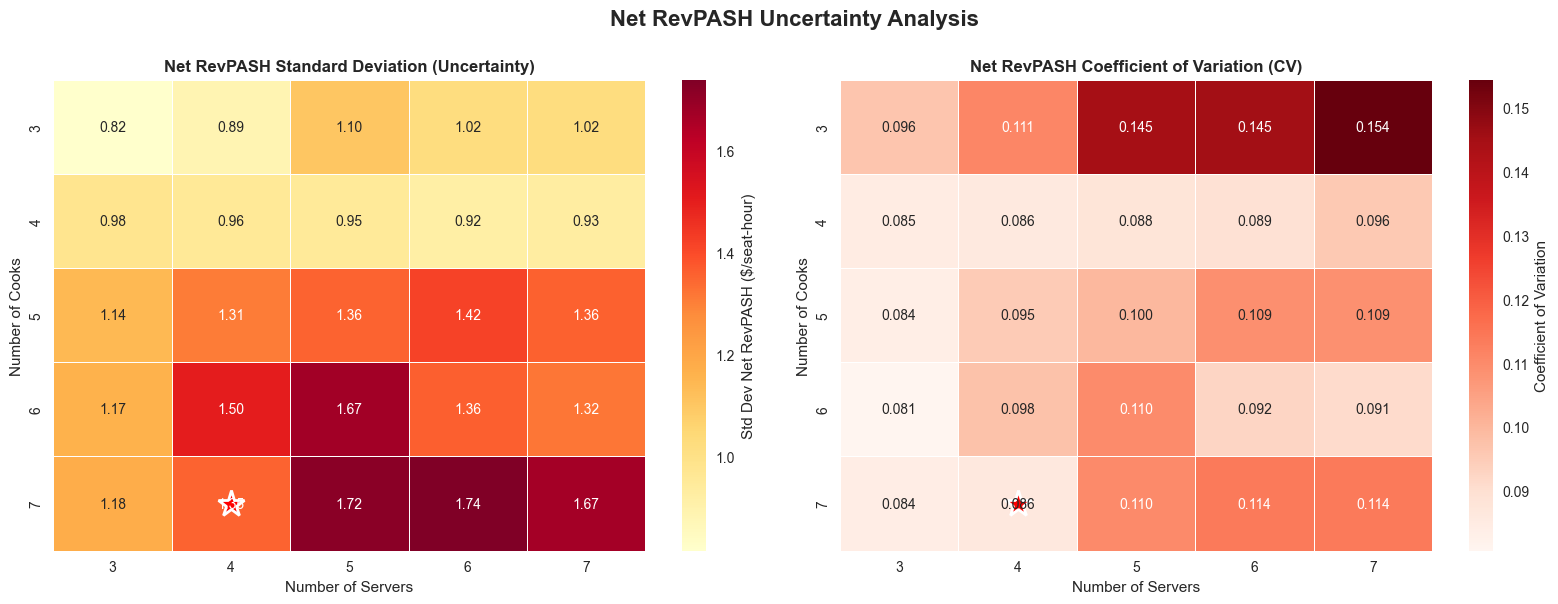


UNCERTAINTY ANALYSIS

Standard Deviation Statistics:
  Maximum Std Dev: $1.74
  Minimum Std Dev: $0.82
  Average Std Dev: $1.23

Coefficient of Variation Statistics:
  Maximum CV: 0.1544 (15.44%)
  Minimum CV: 0.0806 (8.06%)
  Average CV: 0.1029 (10.29%)

Optimal Configuration Uncertainty:
  Net RevPASH: $15.71 ± $1.35
  CV: 0.0862 (8.62%)


In [21]:
# Net RevPASH Standard Deviation Heatmap (showing uncertainty)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Net RevPASH Uncertainty Analysis', fontsize=16, fontweight='bold', y=1.0)

# 1. Standard Deviation Heatmap
pivot_std = viz_df.pivot(index='num_cooks', columns='num_servers', values='net_revpash_std')
sns.heatmap(pivot_std, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Std Dev Net RevPASH ($/seat-hour)'}, ax=axes[0], linewidths=0.5)
axes[0].set_title('Net RevPASH Standard Deviation (Uncertainty)', fontweight='bold')
axes[0].set_xlabel('Number of Servers')
axes[0].set_ylabel('Number of Cooks')
axes[0].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

# 2. Coefficient of Variation (CV) Heatmap
viz_df['net_revpash_cv'] = viz_df['net_revpash_std'] / viz_df['net_revpash_mean']
pivot_cv = viz_df.pivot(index='num_cooks', columns='num_servers', values='net_revpash_cv')
sns.heatmap(pivot_cv, annot=True, fmt='.3f', cmap='Reds', 
            cbar_kws={'label': 'Coefficient of Variation'}, ax=axes[1], linewidths=0.5)
axes[1].set_title('Net RevPASH Coefficient of Variation (CV)', fontweight='bold')
axes[1].set_xlabel('Number of Servers')
axes[1].set_ylabel('Number of Cooks')
axes[1].plot(optimal_x, optimal_y, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("UNCERTAINTY ANALYSIS")
print(f"{'='*70}")
print(f"\nStandard Deviation Statistics:")
print(f"  Maximum Std Dev: ${viz_df['net_revpash_std'].max():.2f}")
print(f"  Minimum Std Dev: ${viz_df['net_revpash_std'].min():.2f}")
print(f"  Average Std Dev: ${viz_df['net_revpash_std'].mean():.2f}")

print(f"\nCoefficient of Variation Statistics:")
print(f"  Maximum CV: {viz_df['net_revpash_cv'].max():.4f} ({viz_df['net_revpash_cv'].max()*100:.2f}%)")
print(f"  Minimum CV: {viz_df['net_revpash_cv'].min():.4f} ({viz_df['net_revpash_cv'].min()*100:.2f}%)")
print(f"  Average CV: {viz_df['net_revpash_cv'].mean():.4f} ({viz_df['net_revpash_cv'].mean()*100:.2f}%)")

print(f"\nOptimal Configuration Uncertainty:")
opt_cv = optimal_config['net_revpash_std'] / optimal_config['net_revpash_mean']
print(f"  Net RevPASH: ${optimal_config['net_revpash_mean']:.2f} ± ${optimal_config['net_revpash_std']:.2f}")
print(f"  CV: {opt_cv:.4f} ({opt_cv*100:.2f}%)")
print(f"{'='*70}")
